# Squared Exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorVAE model on a Gaussian process dataset which is generated using a Squared-Exponential kernel.

In [1]:
import sys
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL

import jax.config as config
config.update("jax_enable_x64", True)

Numpyro version:  0.12.1
JAX version:      0.4.13
Optax version:    0.1.5


### Setup arguments

In [2]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 10,
        "thinning": 1,
       }

### Generate data


In [3]:
kernel = SquaredExponential()

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [4]:
# Generate samples to plot
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

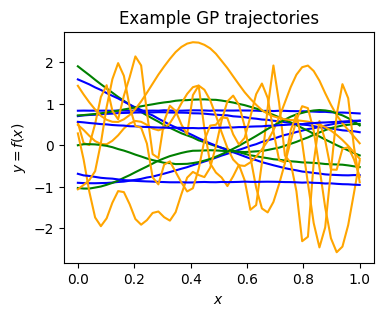

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

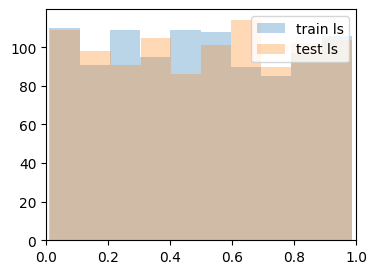

In [6]:
# Lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### VAE Model

In [7]:
conditional = args["conditional"]
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_iterations  = args["num_iterations"]
true_ls     = args["true_ls"]

### Training loop

In [8]:
# define models
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=0.001)
loss = SquaredSumAndKL(conditional=conditional)

trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, num_iterations)

print(f'Training of {num_iterations} epochs took {round(time_taken)} seconds')

[    1] training loss: 6544.378, test loss: 54900.585
[   11] training loss: 4014.785, test loss: 37817.054
[   21] training loss: 3617.760, test loss: 32481.061
[   31] training loss: 2947.633, test loss: 29033.696
[   41] training loss: 2822.505, test loss: 26321.645
[   51] training loss: 2372.450, test loss: 23909.763
[   61] training loss: 2396.078, test loss: 21273.119
[   71] training loss: 1926.732, test loss: 19387.650
[   81] training loss: 1945.137, test loss: 18039.232
[   91] training loss: 1952.572, test loss: 17325.061
[  101] training loss: 1651.992, test loss: 16548.150
[  111] training loss: 1407.684, test loss: 16055.870
[  121] training loss: 1712.092, test loss: 15812.083
[  131] training loss: 1289.955, test loss: 15218.626
[  141] training loss: 1435.218, test loss: 15001.933
[  151] training loss: 1511.595, test loss: 14496.075
[  161] training loss: 1454.652, test loss: 14142.324
[  171] training loss: 1281.736, test loss: 13735.649
[  181] training loss: 1293.

[ 1561] training loss: 715.850, test loss: 7423.115
[ 1571] training loss: 784.908, test loss: 7445.899
[ 1581] training loss: 849.060, test loss: 7439.051
[ 1591] training loss: 704.771, test loss: 7464.711
[ 1601] training loss: 756.652, test loss: 7380.646
[ 1611] training loss: 784.139, test loss: 7410.978
[ 1621] training loss: 804.159, test loss: 7352.991
[ 1631] training loss: 704.315, test loss: 7428.086
[ 1641] training loss: 711.238, test loss: 7418.374
[ 1651] training loss: 656.906, test loss: 7367.474
[ 1661] training loss: 840.395, test loss: 7405.905
[ 1671] training loss: 713.693, test loss: 7320.231
[ 1681] training loss: 750.233, test loss: 7424.310
[ 1691] training loss: 751.702, test loss: 7349.191
[ 1701] training loss: 784.504, test loss: 7258.186
[ 1711] training loss: 724.925, test loss: 7211.511
[ 1721] training loss: 806.181, test loss: 7301.031
[ 1731] training loss: 638.230, test loss: 7268.584
[ 1741] training loss: 823.008, test loss: 7316.724
[ 1751] trai

[ 3141] training loss: 679.572, test loss: 6901.244
[ 3151] training loss: 752.438, test loss: 6936.048
[ 3161] training loss: 718.973, test loss: 6875.158
[ 3171] training loss: 662.992, test loss: 6943.916
[ 3181] training loss: 784.169, test loss: 6852.182
[ 3191] training loss: 695.863, test loss: 7042.611
[ 3201] training loss: 603.968, test loss: 6989.923
[ 3211] training loss: 783.145, test loss: 6946.319
[ 3221] training loss: 600.050, test loss: 6850.827
[ 3231] training loss: 653.552, test loss: 6950.705
[ 3241] training loss: 739.629, test loss: 6966.810
[ 3251] training loss: 722.005, test loss: 6946.240
[ 3261] training loss: 705.643, test loss: 6968.612
[ 3271] training loss: 762.240, test loss: 6844.374
[ 3281] training loss: 663.100, test loss: 7018.178
[ 3291] training loss: 698.922, test loss: 6898.800
[ 3301] training loss: 693.829, test loss: 6885.306
[ 3311] training loss: 611.370, test loss: 6919.448
[ 3321] training loss: 646.725, test loss: 6938.835
[ 3331] trai

Text(0.5, 1.0, 'Test loss')

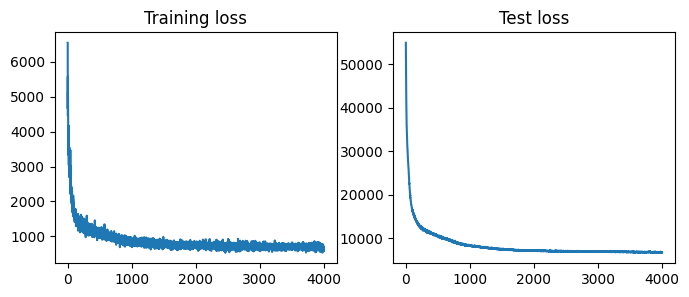

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# plt.figure(figsize=(4,3))
axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


#### What have we learnt?

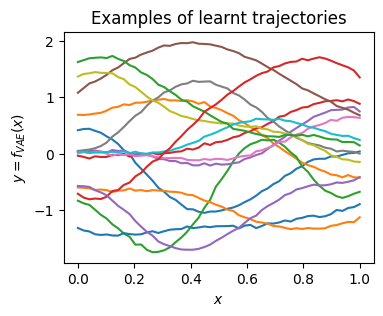

In [10]:
# Get trained decoder params
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))

# create decoder
decoder = MLPDecoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

#### Visual diagnostics

### Inference with MCMC

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

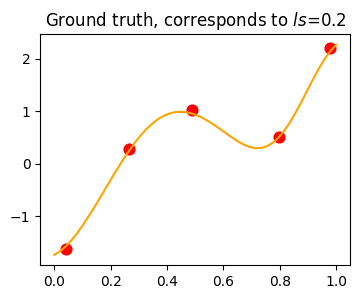

In [11]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

In [12]:
# add data to args
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

#### Nupmyro model

In [13]:
c = true_ls * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

/Users/vermap1/projects/PriorCVAE_JAX/examples/../priorCVAE/mcmc.py:66: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 4. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3479.69it/s, 7 steps of size 4.52e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.03      0.31     -1.05     -1.56     -0.55  29529.76      1.00
      f[1]     -1.07      0.32     -1.09     -1.61     -0.58  29522.01      1.00
      f[2]     -1.09      0.32     -1.11     -1.63     -0.59  29650.53      1.00
      f[3]     -1.05      0.31     -1.06     -1.56     -0.54  30662.16      1.00
      f[4]     -1.03      0.31     -1.05     -1.55     -0.53  31286.38      1.00
      f[5]     -0.97      0.30     -0.99     -1.47     -0.49  33022.58      1.00
      f[6]     -0.85      0.28     -0.86     -1.31     -0.38  35718.78      1.00
      f[7]     -0.77      0.28     -0.78     -1.21     -0.31  38181.92      1.00
      f[8]     -0.67      0.27     -0.68     -1.10     -0.21  39750.21      1.00
      f[9]     -0.52      0.25     -0.53     -0.92     -0.11  42276.48      1.00
     f[10]     -0.37      0.25     -0.37     -0.77      0.04  41933.82      1.00
     f[11]     -0.23      0

Text(0.5, 1.0, 'PriorVAE inference')

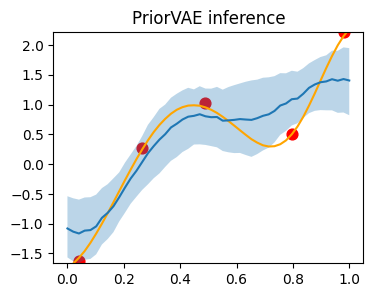

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = .1 * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')